In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as time_pkg

from astropy import units as u

from lib.GPUKeplerSimulation import propagate, average_scaler
from lib.DisplaySimulation import displaySimulation
from lib.AsteroidBelt import generateNearSHODistribution

In [2]:
import cupy as cp
cp.cuda.runtime.getDeviceCount()

1

In [3]:
size = 20000
r_0 = 0.05*u.km
epsilon = 0.0000001*u.kg*u.km**2/u.s
micro = 0.00112*u.km**3/u.s**2 
m = 0.1*u.kg

belt = generateNearSHODistribution(size, micro, m, r_0, epsilon)

In [4]:
J_1 = m*np.sqrt(2*micro*r_0)
print("Action 1: ", J_1)
print("Energy: ", -np.power(m, 3)*np.power(micro,2)/(2*np.power(J_1, 2)))
omega = np.power(m,3)*np.power(micro,2)/np.power(J_1, 3)
omega_prime = -3*np.power(m,3)*np.power(micro,2)/np.power(J_1, 4)
print("Omega_0: ", omega)
print("Omega_prime: ", omega_prime)
print("Decoherence Time: ", 2*np.pi/(omega_prime*epsilon))

# average_radius = 3*sigma_e**2 + 3*sigma_e*sigma_a + 3*sigma_e*np.sqrt(r_0) + 2*sigma_a**2 + 2*sigma_a*np.sqrt(r_0) + r_0
# print("Initial average radius: ", average_radius)

Action 1:  0.0010583005244258364 kg km2 / s
Energy:  -0.00056 kg km2 / s2
Omega_0:  1.0583005244258359 1 / s
Omega_prime:  -2999.9999999999986 1 / (kg km2)
Decoherence Time:  -20943.951023931964 s


In [5]:
timestep = 30*u.second

time_before_kick = 30*u.second
time_after_kick = 21000*u.second
time_after_quad_kick = 21000*u.second

dipole_time = time_before_kick
quad_time = time_before_kick + time_after_kick
end_time = time_before_kick + time_after_kick + time_after_quad_kick

dipole_step = int(np.ceil(dipole_time/timestep))
quad_step = int(np.ceil(quad_time/timestep))
end_step = int(np.ceil(end_time/timestep))


time = np.linspace(0.0*u.second, end_time, end_step)

avr_radius = np.zeros(end_step) * u.km

radiuses = np.zeros((size, end_step)) * u.km
velocities = np.zeros((size, end_step)) * u.km/u.s

In [6]:
gpuStart = time_pkg.time()
radiuses[:,0:dipole_step], velocities[:,0:dipole_step], final_mean_anamoly = propagate(belt, dipole_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

GPU Time:  0.045998573303222656  Astro Time:  0.0010025501251220703


In [7]:
avr_radius[0:dipole_step] = average_scaler(radiuses, end=dipole_step)

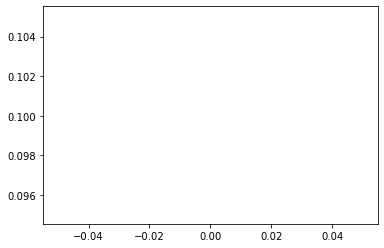

In [8]:
plt.plot(time[0:dipole_step], avr_radius[0:dipole_step])

In [9]:
belt.radial_kick(0.004040*u.km)

In [10]:
gpuStart = time_pkg.time()
radiuses[:,dipole_step:quad_step], velocities[:,dipole_step:quad_step], final_mean_anamoly = propagate(belt, quad_time-dipole_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

GPU Time:  0.6859982013702393  Astro Time:  0.0


In [11]:
avr_radius[dipole_step:quad_step] = average_scaler(radiuses, start=dipole_step, end=quad_step)

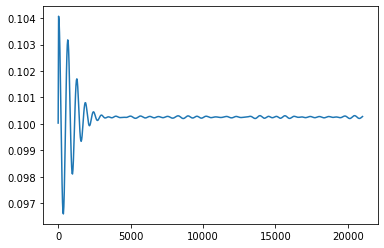

In [12]:
plt.plot(time[0:quad_step], avr_radius[0:quad_step])


In [13]:
belt.radial_quadrapole_kick(0.01 * u.s**-1, r_0)

In [14]:
gpuStart = time_pkg.time()
radiuses[:,quad_step:end_step], velocities[:,quad_step:end_step], final_mean_anamoly = propagate(belt, end_time - quad_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

GPU Time:  0.6859986782073975  Astro Time:  0.0


In [15]:
avr_radius[quad_step:end_step] = average_scaler(radiuses[quad_step:end_step], start=quad_step, end=end_step)

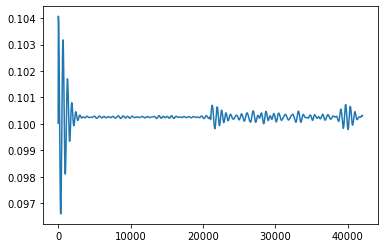

In [16]:
plt.plot(time[0:end_step], avr_radius[0:end_step])